In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from matplotlib import pyplot as plt
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import funciones_FS as f_FS
import funciones_TS as f_TS
import DQM as f_DQM

import importlib

pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow
pd.set_option('precision', 4) # Todos los valores de los dataframe de pandas tendrán 4 decimales
# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/Datos/"
#archivo = "DF"
#sensor = "pm25"
redondeo = 4
df_CS = pd.read_csv(ruta+"datosCoordenados_CS.csv",sep=",")
df_SIATA = pd.read_csv(ruta+"datosCoordenados_SIATA.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento.csv",sep=",")
#datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")

#variables = ['pm25']#,'humedad_relativa', 'temperatura'
#for sensor in variables:
#    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
#    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

#print("cantidad de datos de test: ", len(datos))

#### EXTRACCIÓN DE DATOS

In [2]:
# Fecha del análisis
year = '2020'
mes = '02'
dias = 29

# Estación SIATA de referencia
estacionSIATA = 80

#Extracción de los datos del nodo SIATA
datos_SIATA = f_FS.extrac_data_SIATA(df_SIATA, estacionSIATA, year, mes)

# Extracción de los datos de los nodos CS de acuerdo con la estación SIATA seleccionada
datos, nodosCS = f_FS.extrac_data_CS(df_CS, estacionSIATA, year, mes)


#### ORGANIZACIÓN DE DATOS POR HORAS O POR MINUTOS

In [3]:
# DATAFRAME CON DATO POR MINUTO
sensores = ['pm25_df']
sensor = nsensor = sensores[-1]
datosTest = datos.loc[datos.loc[:,'codigoSerial'] == nodosCS[0]]
#datosTest.loc[datosTest[sensor] > 100, sensor] = np.nan
datosTest = datosTest.dropna(subset=[sensor])
datosTest['fechaHora'] = datosTest['fecha'] + ' ' + datosTest['hora']
datosTest['fechaHora'] = pd.to_datetime(datosTest['fechaHora'])
datosTest.sort_values('fechaHora', inplace=True)
datosTest.set_index('fechaHora', inplace=True)
#predicciones = datosTest[[sensor]].copy()
datosTest[sensor].mean()
#datosTest

dq_measure_CS = pd.DataFrame()
dq_measure_CS = f_DQM.completitud(datosTest, [nodosCS[0]], dq_measure_CS, dias, 1440, debug = 'N')

In [ ]:
# DATAFRAME CON DATO PROMEDIO POR HORA
sensores = ['pm25_df']
sensor = nsensor = sensores[-1]
datosTest = datos.loc[datos.loc[:,'codigoSerial'] == nodosCS[0]] # Se está eligiendo solo un nodo
datosTest = datosTest.dropna(subset=[sensor])
datosTest = datosTest.groupby(['fecha','time']).mean() # Saca promedio de cada hora
datosTest = pd.DataFrame(datosTest)
datosTest = datosTest.reset_index()

datosTest = datosTest.rename({'time': 'hora'}, axis=1)
datosTest.insert(0,"codigoSerial",nodosCS[0],True)
datosTest['fechaHora'] = datosTest['fecha'] + ' ' + datosTest['hora']
datosTest['fechaHora'] = pd.to_datetime(datosTest['fechaHora'])

datosTest.sort_values('fechaHora', inplace=True)
datosTest.set_index('fechaHora', inplace=True)
print(datosTest[sensor].mean())

dq_measure_CS = pd.DataFrame()
dq_measure_CS = f_DQM.completitud(datosTest, [nodosCS[0]], dq_measure_CS, dias, 24, debug = 'N')
dq_measure_CS

In [ ]:
# Sacar promedio de valores por hora
sensores = ['pm25_df']
sensor = nsensor = sensores[-1]

datosTest = datos.loc[datos.loc[:,'codigoSerial'] == nodosCS[0]] # Se está eligiendo solo un nodo
datosTest = datosTest.dropna(subset=[sensor])
datosTest = datosTest[['codigoSerial','fecha','hora',sensor]]
datosTest['fechaHora'] = datosTest['fecha'] + ' ' + datosTest['hora']
datosTest = datosTest[['codigoSerial','fechaHora',sensor]]
print(datosTest.head(5))
datosTest['fechaHora'] = pd.to_datetime(datosTest['fechaHora'])
datosTest = datosTest.set_index('fechaHora')
#df = df['2020-02-01':'2020-02-10'].resample('H').mean()
datosTest = datosTest.resample('H').mean()
print(datosTest.head(5))

dq_measure_CS = pd.DataFrame()
dq_measure_CS = f_DQM.completitud(datosTest, [nodosCS[0]], dq_measure_CS, dias, 24, debug = 'N')
dq_measure_CS

In [3]:
# DATAFRAME CON LOS DATOS DE LOS SENSORES ROBUSTOS

sensores = ['pm25']
sensor = nsensor = sensores[-1]
datosTest = datos_SIATA.copy()
datosTest['fechaHora'] = pd.to_datetime(datosTest['fechaHora'])
datosTest.loc[datosTest[sensor] > 200, sensor] = np.nan
datosTest.loc[datosTest[sensor] <= 0, sensor] = np.nan
#datosTest = datosTest[datosTest['pm25'].notna()] # Para eliminar la fila con NaN en cualquier columna
datosTest = datosTest.dropna(subset=[sensor]) # Para eliminar la fila con NaN solo en la columna indicada
#datosTest.sort_values('fechaHora', inplace=True)
datosTest.set_index('fechaHora', inplace=True)
datosTest[sensor].mean()
#datosTest

27.32633139830512

#### GRAFICO DE LOS DATOS

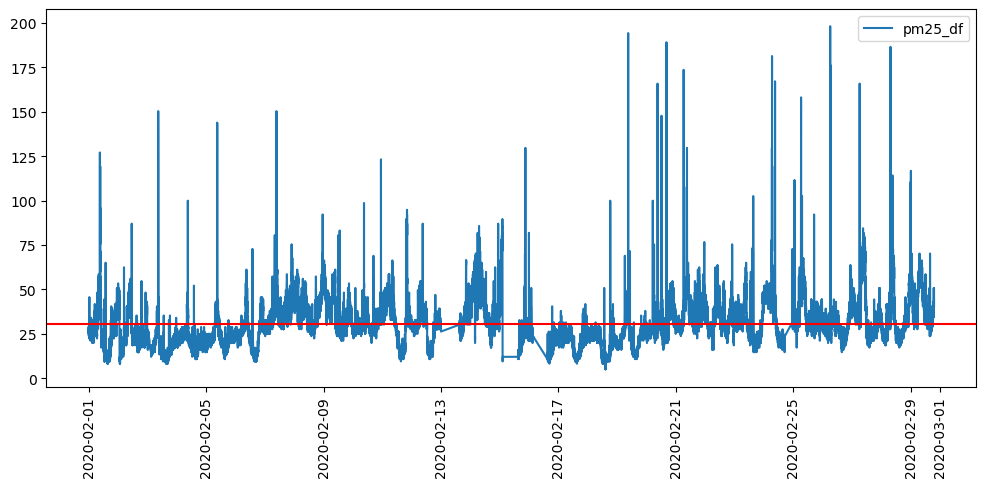

In [9]:
a = 0
#b = 210
b = len(datosTest)
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(datosTest[a:b].index, datosTest[a:b][sensor], label=sensor)
plt.axhline(y=datosTest[a:b][sensor].mean(), color='r', linestyle='-')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

### 1) IDENTIFICACIÓN DEL MODELO

In [10]:
# Inicialización del orden para el modelo ARIMA
p = d = q = 0   # AR - I - AM

#### 1.1) VERIFICAR ESTACIONARIEDAD

##### a) Estacionariedad en varianza (Homocedasticidad)
Hay dos formas: 
1) Analizando el gráfico de los datos y estimar a ojo si parece hacer varainza constante.

2) Verificando que la varianza no sea la misma en todo el dataset. Para esto, el dataset puede ser dividido en partes y aplicar un test de contraste de las varianzas de cada parte.


Datos: pm25_df

Varianza general 159.02463222119317 
Varianzas. [129.19035855957375, 55.79283356065649, 139.23879824905268, 103.48594549646847, 189.07074488860388, 56.61524195009701, 160.99321374985522, 88.02445151852004, 157.3544159751109, 196.61323484946038] 
Desviación de las varianzas 47.981980189018635


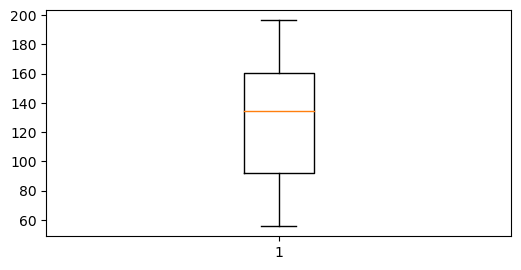


**** Test de Flinger-Killeen ****
H0: Las varianzas son iguales
El estadístico es: 1881.0194026510674
El p-value es: 0.0
Se rechaza H0, la serie NO es estacionaria en varianza


In [11]:
### MODO DE PRUEBA 2
### Se divide el dataset en n partes y se calcula la varianza de cada parte, luego se comparan.
### Si las varianzas son iguales o similares, se puede considerar estacionariedad en varianza, de lo contrario no.

N = 10   # Número de partes en las que se dividirá el dataset

print('Datos:', nsensor)
f_TS.var_divi(datosTest[nsensor], N)


### Existen varios test de Homocedasticidad:
### 1) F-test (razón de varianzas): Compara dos poblaciones. Se requiere normalidad de las muestras.
### 2) Test de Levene: Compara 2 o más poblaciones, no es muy estricto con la normalidad, pero se requiere que las
###    poblaciones sean del mismo tamaño.
### 3) Test de Bartlett: Compara 2 o más poblaciones, pero es más sensible a la falta de normalidad que el Test
###    de Levene. Las poblaciones pueden ser de direferenres tamaños.
### 4) Test de Fligner-Killeen: Es un test no paramétrico que compara 2 o mas poblaciones. 
###    No requiere normalidad en los datos, por lo que se basa en la mediana.

# TEST DE FLINGER-KILLEEN
# H0: Las varianzas son estadísticamente iguales con un intervalo de confianza del 95%.
# Si el valor-p está por encima del valor crítico de 0.05 (para un 95% de confiabilidad), entonces no se rechaza H0

flinger = f_TS.flinger_test(datosTest[nsensor], N)


##### a.1) Transformación de los datos
Si no se cuenta con estacionariedad de la varianza, se debe aplicar una transformación de los datos.  Para series que contienen solo valores positivos y sin valores cero, se recomienda utilizar una transformación logarítmica. En este caso se utiliza la transformación de Box-Cox, la cuak se enfoca en la estabilización de varianza.

<img src="Box-Cox.png" width="300">

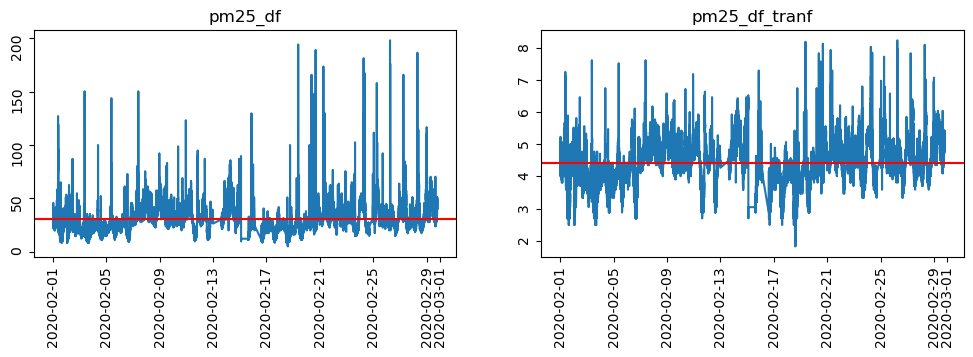

In [12]:
if not flinger:
    sensores.append(nsensor+'_tranf')
    if len(sensores) > 2:
        sensor = sensores[-2]

    xt,lmbda = stats.boxcox(datosTest[nsensor])
    nsensor = sensores[-1]
    datosTest[nsensor] = xt

#upper_invert = special.inv_boxcox(datosTest['boxcox'], lmbda)
#datosTest['inv_boxcox'] = upper_invert

fig = plt.figure(figsize=(12, 3), dpi=100)
ax1=fig.add_subplot(121)
ax1.plot(datosTest[sensor])
ax1.axhline(y=datosTest[sensor].mean(), color='r', linestyle='-')
ax1.tick_params(rotation=90)
ax1.set_title(sensor)

ax2=fig.add_subplot(122)
ax2.plot(datosTest[nsensor])
ax2.axhline(y=datosTest[nsensor].mean(), color='r', linestyle='-')
ax2.tick_params(rotation=90)
ax2.set_title(nsensor)
plt.show()


##### b) Estacionariedad en media
Hay dos formas: 
1) Calculando la media para todo el dataset, puede ser dividiéndolo en partes y calculando la media de cada parte
2) Utilizando una prueba de existencia de raiz unitaria. La recomendada es la pruena de Dickey-Fuller Aumentada, la cual aplica para modelos con un factor de regresión mayor a 1.

Datos: pm25_df_tranf

Media general 4.424954805875091 
Medias [4.008421717952508, 4.015503008278776, 4.691379497947018, 4.579968845011643, 4.740876353184799, 3.8176940111810937, 4.360429764861524, 4.668100030712408, 4.613914362390828, 4.751759181323234] 
Desviación de las medias 0.33324522851721367


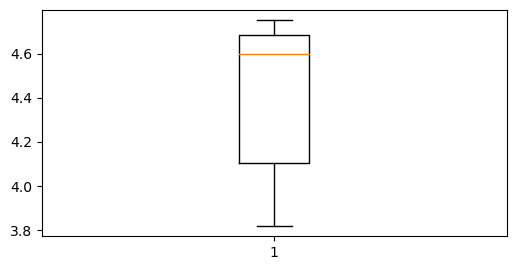


**** Test de Dickey Fuller Aumentada ****
H0: Existe raiz unitaria en la serie
El estadístico es: -8.42384935899407
El p-value es: 1.9507338955457836e-13
El número de lag es: 25
Los valores críticos son: {'1%': -3.430520341146082, '5%': -2.8616152867865847, '10%': -2.5668100727538623}
De acuerdo con el p-value, Se rechaza H0, la serie es estacionaria en media


In [13]:
### MODO DE PRUEBA 1
### Se divides datos normales o transformados si es el caso en n partes y se calcula la media de cada parte, luego se comparan.
### Si las medias son iguales o similares, se puede considerar estacionariedad en media, de lo contrario no.

print('Datos:', nsensor)
f_TS.med_divi(datosTest[nsensor], N)

### MODO DE PRUEBA 2
### Se aplica la prueba de Dickey-Fuller Aumentada a los datos originales o transformados si es el caso, para verificar si 
### existe raiz unitaria.

# Dickey Fuller Aumentada
# H0: Existe raiz unitaria en la serie
# Si el valor-p está por encima del valor crítico de 0.05 (para un 95% de confiabilidad), entonces no se rechaza que 
# haya una raiz unitaria
# If the p-value is above a critical size, then we cannot reject that there is a unit root.

dickey = f_TS.dickey_aum_test(datosTest[nsensor])

Si se obtiene la estacionariedad sin transformación, entonces el modelo ARIMA no requiere diferenciación y se reduce a un modelo ARMA. Si no se obtiene la estacionariedad, la serie se debe tranformar en diferencia tantas veces como sea necesario hasta que se obtenga la estacionariedad, y esa cantidad de veces es el valor del parámetro d para la I (Intregración) del modelo ARIMA.

##### a.1) Transformación por diferenciación de los datos
Si no se cuenta con estacionariedad de la media, se debe aplicar una transformación de los datos. Para eso se recomienda una transfomación por diferencia, la cual consiste en eliminar la tendencia hallando la diferencia del valor t menos el valor t-1

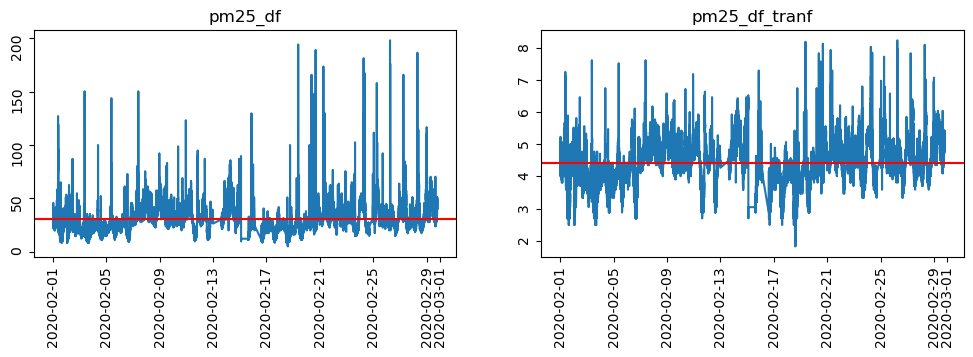

In [14]:
if not dickey:
    d += 1
    sensores.append(nsensor+'_diff')

    nsensor = sensores[-1]
    if len(sensores) > 2:
        sensor = sensores[-2]

    datosTest[nsensor] = datosTest[sensor] - datosTest[sensor].shift(1)
    datosTest = datosTest.dropna(subset=[nsensor]) # Para eliminar la fila con NaN solo en la columna indicada

fig = plt.figure(figsize=(12, 3), dpi=100)
ax1=fig.add_subplot(121)
ax1.plot(datosTest[sensor])
ax1.axhline(y=datosTest[sensor].mean(), color='r', linestyle='-')
ax1.tick_params(rotation=90)
ax1.set_title(sensor)

ax2=fig.add_subplot(122)
ax2.plot(datosTest[nsensor])
ax2.axhline(y=datosTest[nsensor].mean(), color='r', linestyle='-')
ax2.tick_params(rotation=90)
ax2.set_title(nsensor)
plt.show()

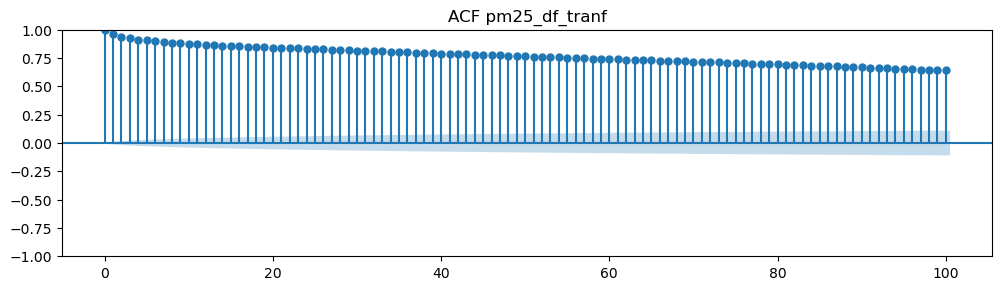

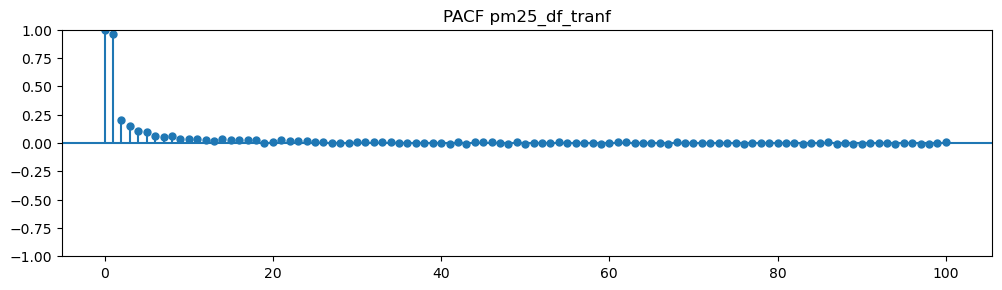

Banda de confianza entre +- 0.0102


In [15]:
### CALCULO Y GRAFICOS DEL ACF Y EL PACF
lags = 100

plt.rc("figure", figsize=(12,3), dpi=100)
plot_acf(datosTest[nsensor], lags=lags)
plt.title('ACF '+nsensor)
plt.show()

plt.rc("figure", figsize=(12,3), dpi=100)
plot_pacf(datosTest[nsensor], lags=lags, method='ywm')
plt.title('PACF '+nsensor)
plt.show()

acf, acf_conf = stattools.acf(datosTest[nsensor], nlags=lags, alpha=0.05)
pacf, pacf_conf = stattools.pacf(datosTest[nsensor], nlags=lags, method='ywm', alpha=0.05)
banda = round(2/np.sqrt(len(datosTest[nsensor])),4)
print('Banda de confianza entre +-', banda)

Con esta información ya se puede estimar un modelo ARIMA probable. 

Para el factor de AR se toma la cantidad de valores que al inicio están por fuera de la banda de confianza del PACF hasta el fatcor de corte, es decir, hasta el primer valor que esté dentro de sa banda de coanfianza.

La zona de significancia o banda de confianza para los coeficientes de la correlación está delimitada por 

<img src="banda_confianza.png" width="80">

Para el factor de AM se toma la cantidad de valores que al inicio están por fuera de la banda de confianza del ACF hasta el fatcor de corte, es decir, hasta el primer valor que esté dentro de sa banda de coanfianza.

In [16]:
### CALCULO DE LOS FACTORES p y q UTILIZANDO LOS RESULTADOS DE ACF Y EL PACF

if p == 0:
    for i in pacf_conf[1:]:
        if i[0] < 0:
            break
        p += 1

if q == 0:
    for i in acf_conf[1:]:
        if i[0] < 0:
            break
        q += 1


print('AR -->',p)
print('I  -->',d)
print('MA -->',q)


AR --> 18
I  --> 0
MA --> 100


#### 1.2) INCLUSIÓN DEL TÉRMINO INDEPENDIENTE
Para decidir si se incluye un término independiente no nulo en el modelo, se contrastará si la media de la serie estacionaria es o no cero.

<img src="hip_termino_indep.png" width="200">

El estadístico de contrate es:

<img src='Estadistico_contraste.png' width="250">

donde el estimador de varianza de la media muestral viene dado por:

<img src="varianza_media_muestral.png" width="400">, donde <img src="variaza_serie_estacionaria.png" width="250"> es la varianza de la serie estacionaria. Sin embargo, en ocasoines se aplica la siguiente proximación: 

<img src="aprox_varianza_media_muestral.png" width="120">, donde <img src="longitud_serie_estacionaria.png" width="120"> es la longitudd de la serie estacionaria.


Se rechazará la H0 : E(zt) = 0 a un nivel de signiﬁcación α y, por lo tanto, se incluirá el parámetro δ en el modelo si:
<img src="t_termino_indep.png" width="200">

In [17]:
# Se calculan los estadísticos de la serie
datosTest[nsensor].describe()

# Obtenemos la varianza y la media de la muestra de la serie
Co = datosTest[nsensor].var()
zeta = datosTest[nsensor].mean()

# Calculamos el estimador de varianza de la media muestral utilizando el modelo aproximado
sigma_z= Co/len(datosTest[nsensor])

# Calculamos el valor del estadídtico de contrate
t =  zeta/sigma_z

# Obtenemos el valor de la distribución con un 95% de intervalo de confianza (Es de 2 colas porque la hipótesis es una igualdad)
t_muestral = stats.t.ppf(q=1-.05/2, df=len(datosTest[nsensor]))

# Comparamos el valor del estadístico con el valor de la distribución para saber si se rechaza o no la hipótesis nula
print('Valor t:',round(t,2),'\nValor t muestral:',round(t_muestral,2))
if t > t_muestral:
    print('Se rechaza H0. Se debe incluir un término constante en el modelo')
else:
    print('No se rechaza H0. No se debe incluir un término constante en el modelo')
  

Valor t: 377019.07 
Valor t muestral: 1.96
Se rechaza H0. Se debe incluir un término constante en el modelo


#### MODELO ARIMA

The Root Mean Squared Error of ARIMA (1, 0, 6) trend is 0.93


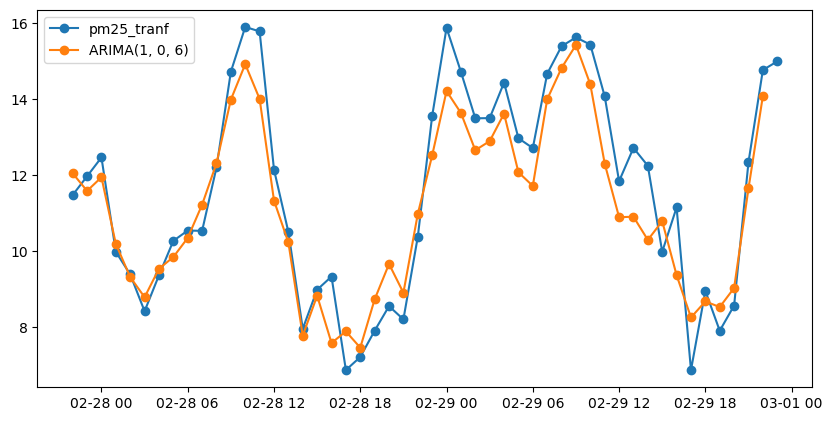

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       pm25_tranf   No. Observations:                  472
Model:             ARIMA(1, 0, 6)x(1, 0, 6, 24)   Log Likelihood                -979.636
Date:                          Fri, 28 Oct 2022   AIC                           1991.272
Time:                                  17:54:21   BIC                           2057.784
Sample:                                       0   HQIC                          2017.435
                                          - 472                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7195      0.526     18.491      0.000       8.689      10.750
ar.L1          0.3433      0.270      1.273      0.203      -0.185       0.872
ma.L1          0.3148      0.267      1.178      0.239      -0.209       0.839
ma.L2          0.3109      0.177      1.756      0.079      -0.036       0.658
ma.L3          0.2416      0.149      1.620      0.105      -0.051       0.534
ma.L4          0.1915      0.120      1.602      0.109      -0.043       0.426
ma.L5          0.1884      0.094      2.012      0.044       0.005       0.372
ma.L6          0.0866      0.085      1.017      0.309      -0.080       0.254
ar.S.L24       0.6455      0.595      1.085      0.278      -0.521       1.812
ma.S.L24      -0.5129      0.601     -0.853      0.394      -1.692       0.666
ma.S.L48       0.0933      0.095      0.979      0.328      -0.094       0.280
ma.S.L72      -0.0597      0.118     -0.506      0.613      -0.291       0.172
ma.S.L96       0.0296      0.063      0.467      0.641      -0.095       0.154
ma.S.L120     -0.0429      0.077     -0.556      0.579      -0.194       0.109
ma.S.L144      0.0610      0.060      1.018      0.309      -0.056       0.178
sigma2         3.6899      0.202     18.292      0.000       3.295       4.085
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               109.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.62
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
import statsmodels.api as sm

a = len(datosTest)-50
b = len(datosTest)

rmse = pd.DataFrame(columns=['Metodo', 'Parámetros', 'RMSE'])

modelo = sm.tsa.ARIMA(datosTest[nsensor], order=(p, d, q+1),seasonal_order=(p,d,q+1,24))
resultados = modelo.fit()  
datosTest['pronostico_arima'] = resultados.fittedvalues.shift(-1)
mse1 = ((datosTest['pronostico_arima'] - datosTest[nsensor]) ** 2).mean()
print('The Root Mean Squared Error of ARIMA', modelo.order,'trend is', format(round(np.sqrt(mse1), 2)))

lista1 = {'Metodo':'ARIMA', 'Parámetros': modelo.order, 'RMSE':round(np.sqrt(mse1), 2)}
rmse = rmse.append(lista1, ignore_index=True)

plt.figure(figsize=(10,5))
plt.plot(datosTest[nsensor][a:b], label=nsensor, marker="o")
plt.plot(datosTest['pronostico_arima'][a:b], label='ARIMA'+str(modelo.order), marker="o")
#plt.plot(fcast1, label='Forecast', marker="o")
plt.legend(loc='best')
plt.show()

resultados.summary()

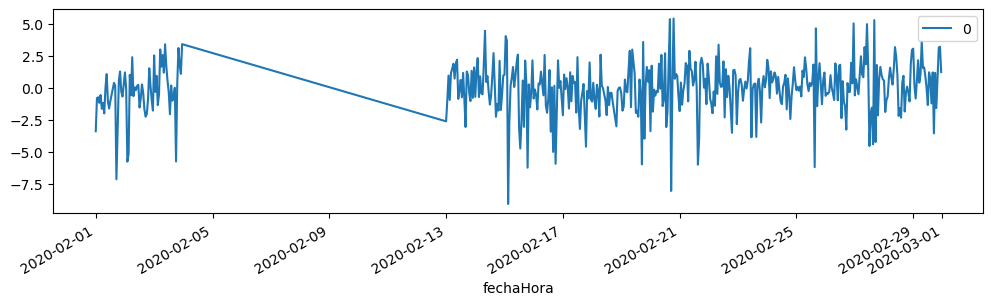

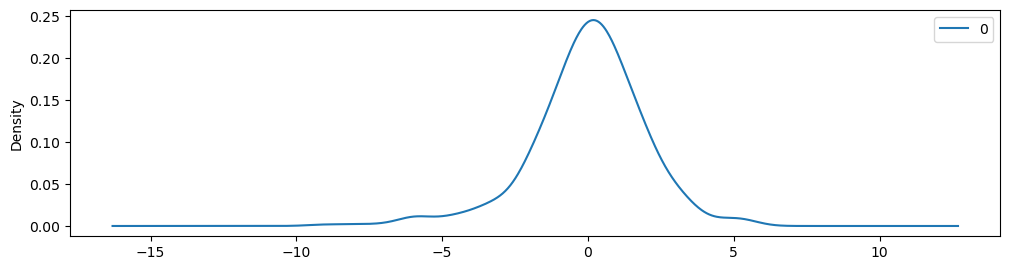

              0
count  472.0000
mean     0.0024
std      1.9622
min     -9.0578
25%     -0.9358
50%      0.1274
75%      1.1168
max      5.4398


In [100]:

residuals = pd.DataFrame(resultados.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

5.849252879747664

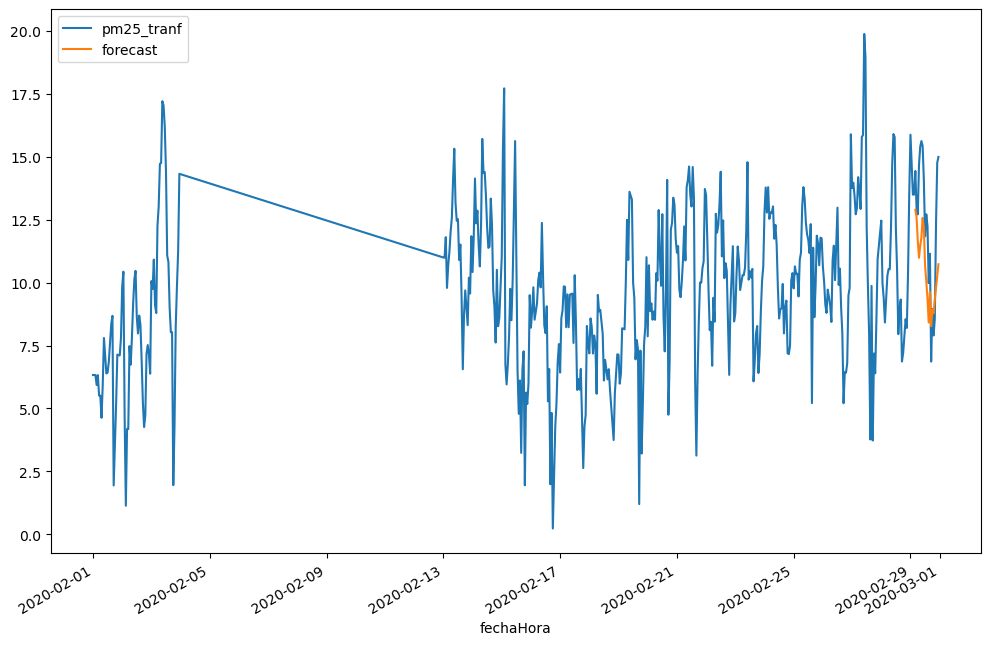

In [119]:

datosTest['forecast']=resultados.predict(start=len(datosTest)-20,end=len(datosTest)-1,dynamic=True)
datosTest[[nsensor,'forecast']].plot(figsize=(12,8))
((datosTest[nsensor][len(datosTest)-30:len(datosTest)-1] - datosTest['forecast'][len(datosTest)-30:len(datosTest)-1])**2).mean()

#mse1 = ((datosTest['pronostico_arima'] - datosTest[nsensor]) ** 2).mean()

In [54]:
#from pandas.tseries.offsets import DateOffset
#future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,60)]

datosTest.loc[datosTest['forecast'].notna()]
len(datosTest)

472

### 2) ESTIMACIÓN DE LOS PARÁMETROS DESCONOCIDOS DEL MODELO

In [ ]:
## PERIODOGRAMA
# Fuente: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html

from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()

f, Pxx_den = signal.periodogram(datosTest[sensor])
plt.figure(figsize=(12, 5), dpi=100)
plt.semilogy(f, Pxx_den)
#plt.ylim([1e1, 1e5])
#plt.xlim([0.003, 0.004])  # 0.0031Hz
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
Pxx_den.min()

In [ ]:
# PERIODOGRAMA
# Fuente: http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html

sampling_freq = 1/3600          ########## el tiempo de muestreo es cada hora, es decir, cada 3600 segundos

# Determine frequencies
f = np.fft.fftfreq(len(datosTest)) * sampling_freq

# Compute power spectral density
psd = np.abs(np.fft.fft(datosTest[sensor].values))**2 / len(datosTest)

# Make plot
plt.plot(f[f>=0], psd[f>=0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)

# The very low frequency peak at  f=0  corresponds to the constant, or DC, signal. 

In [ ]:
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(datosTest['boxcox'], model='additive', period=30)  
plt.rc("figure", figsize=(10,5), dpi=100)
figure = descomposicion.plot()

### VERIFICAR ESTACIONARIDAD

In [ ]:
# FUNCIÓN DE AUTOCORRELACIÓN SIMPLE (FAC)  
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rc("figure", figsize=(12,5), dpi=100)
plot_acf(datosTest[sensor], lags=len(datosTest)/3)
plt.show()




In [ ]:
# FUNCIÓN DE AUTOCORRELACIÓN PARCIAL (FAP) 

plt.rc("figure", figsize=(12,5), dpi=100)
plot_pacf(datosTest[sensor], lags=len(datosTest)/3, method='ywm')
plt.show()

In [ ]:
# PRUEBAS DE ESTACIONARIDAD
from statsmodels.tsa import stattools

# Dickey Fuller Aumentada
# H0: Existe raiz unitaria en la serie
# If the p-value is above a critical size, then we cannot reject that there is a unit root.

print('**** Test de Dickey Fuller Aumentada ****')
adf = stattools.adfuller(datosTest[sensor], autolag='AIC')
print('H0: Existe raiz unitaria en la serie')
print('El estadístico es:', adf[0])
print('El p-value es:', adf[1])
print('El número de lag es:', adf[2])
print('Los valores críticos son:', adf[4])
if adf[1] < 0.05:
    adf_b = True
    print("De acuerdo con el p-value, Se rechaza H0, la serie es estacionaria")
else:
    adf_b = False
    print("De acuerdo con el p-value, No se rechaza H0, la serie NO es estacionaria")


# KPSS - Kwiatkowski–Phillips–Schmidt–Shin
# H0: No existe raiz unitaria en la serie
# If the p-value is above a critical size, then we cannot reject that there is a unit root.

print('\n**** Test KPSS ****')
kpss_t = stattools.kpss(datosTest[sensor], nlags='auto')
print('H0: No existe raiz unitaria en la serie')
print('El estadístico es:', kpss_t[0])
print('El p-value es:', kpss_t[1])
print('El número de lag es:', kpss_t[2])
print('Los valores críticos son:', kpss_t[3])
if kpss_t[1] < 0.05:
    kpss_b = False
    print("De acuerdo con el p-value, Se rechaza H0, la serie No es estacionaria")
else:
    kpss_b = True
    print("De acuerdo con el p-value, No se rechaza H0, la serie es estacionaria")

# Fuente: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html?highlight=kpss
if adf_b and kpss_b:
    #Case 1: Both tests conclude that the series is stationary - The series is stationary
    print('\n*** La serie es estacionaria')
elif not adf_b and not kpss_b: 
    #Case 2: Both tests conclude that the series is not stationary - The series is not stationary
    print('\n*** La serie NO es estacionaria')
elif not adf_b and kpss_b:
    #Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
    print('\n*** La serie es estacionaria en tendencia')
elif adf_b and not kpss_b:
    #Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
    print('\n*** La serie es estacionaria en diferencia')

In [ ]:
# Se elimina la tendencia hallando la diferencia del valor t menos el valor t-1
nsensor = sensor+'_diff'
datosTest[nsensor] = datosTest[sensor] - datosTest[sensor].shift(1)
datosTest = datosTest.dropna(subset=[nsensor]) # Para eliminar la fila con NaN solo en la columna indicada

a = 0
#b = 210
b = len(datosTest)
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(datosTest[a:b].index, datosTest[a:b][nsensor], label=nsensor)
plt.axhline(y=datosTest[a:b][nsensor].mean(), color='r', linestyle='-')
plt.legend(loc='upper center')
plt.show()

In [ ]:
# Dickey Fuller Aumentada
# H0: Existe raiz unitaria en la serie
# If the p-value is above a critical size, then we cannot reject that there is a unit root.

print('**** Test de Dickey Fuller Aumentada ****')
adf = stattools.adfuller(datosTest[nsensor], autolag='AIC')
print('H0: Existe raiz unitaria en la serie')
print('El estadístico es:', adf[0])
print('El p-value es:', adf[1])
print('El número de lag es:', adf[2])
print('Los valores críticos son:', adf[4])
if adf[1] < 0.05:
    adf_b = True
    print("De acuerdo con el p-value, Se rechaza H0, la serie es estacionaria")
else:
    adf_b = False
    print("De acuerdo con el p-value, No se rechaza H0, la serie NO es estacionaria")


# KPSS - Kwiatkowski–Phillips–Schmidt–Shin
# H0: No existe raiz unitaria en la serie
# If the p-value is above a critical size, then we cannot reject that there is a unit root.

print('\n**** Test KPSS ****')
kpss_t = stattools.kpss(datosTest[nsensor], nlags='auto')
print('H0: No existe raiz unitaria en la serie')
print('El estadístico es:', kpss_t[0])
print('El p-value es:', kpss_t[1])
print('El número de lag es:', kpss_t[2])
print('Los valores críticos son:', kpss_t[3])
if kpss_t[1] < 0.05:
    kpss_b = False
    print("De acuerdo con el p-value, Se rechaza H0, la serie No es estacionaria")
else:
    kpss_b = True
    print("De acuerdo con el p-value, No se rechaza H0, la serie es estacionaria")

# Fuente: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html?highlight=kpss
if adf_b and kpss_b:
    #Case 1: Both tests conclude that the series is stationary - The series is stationary
    print('\n*** La serie es estacionaria')
elif not adf_b and not kpss_b: 
    #Case 2: Both tests conclude that the series is not stationary - The series is not stationary
    print('\n*** La serie NO es estacionaria')
elif not adf_b and kpss_b:
    #Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
    print('\n*** La serie es estacionaria en tendencia')
elif adf_b and not kpss_b:
    #Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
    print('\n*** La serie es estacionaria en diferencia')

In [ ]:
# FUNCIÓN DE AUTOCORRELACIÓN SIMPLE (FAC)  
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rc("figure", figsize=(12,5), dpi=100)
plot_acf(datosTest[nsensor], lags=100)
plt.show()


# FUNCIÓN DE AUTOCORRELACIÓN PARCIAL (FAP) 

plt.rc("figure", figsize=(12,5), dpi=100)
plot_pacf(datosTest[nsensor], lags=100, method='ywm')
plt.show()

## PRONÓSTICOS

### Simple Exponential Smoothing (SES)
for data without trend or seasonality

This model calculates the forecasting data using weighted averages. One important parameter this model uses is the smoothing parameter: α, and you can pick a value between 0 and 1 to determine the smoothing level. When α = 0, the forecasts are equal to the average of the historical data. When α = 1, the forecasts will be equal to the value of the last observation.

<img src="SES.png">

where:

St+1 is the predicted value for the next time period

St is the most recent predicted value

yt is the most recent actual value

a (alpha) is the smoothing factor between 0 and 1


In [ ]:
# Basado en https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

rmse = pd.DataFrame(columns=['Metodo', 'Parámetros', 'RMSE'])

a = 0
b = 50

smoothing_level = 0.8

# specific smoothing level
fit1 = SimpleExpSmoothing(datosTest[nsensor]).fit(smoothing_level=smoothing_level,optimized=False)
#fcast1 = fit1.forecast().rename(r'$\alpha={}$'+str(smoothing_level))
fcast1 = fit1.forecast(24).rename(r'$\alpha={}$'.format(smoothing_level))
#fcast1.plot(marker='o', color='blue', legend=True)
#fit1.fittedvalues[a:b].plot(marker='o',  color='blue')
mse1 = ((fit1.fittedvalues - datosTest[nsensor]) ** 2).mean()
MSE11 = mean_squared_error(fit1.fittedvalues, datosTest[nsensor])
 
RMSE1 = np.sqrt(MSE11)
print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {} and {}'.format(smoothing_level,round(np.sqrt(mse1), 2), RMSE1))

## auto optimization
fit2 = SimpleExpSmoothing(datosTest[nsensor]).fit()
fcast2 = fit2.forecast(24).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
# plot
#fcast2.plot(marker='o', color='green', legend=True)
#fit2.fittedvalues[a:b].plot(marker='o', color='green')
mse2 = ((fit2.fittedvalues - datosTest[nsensor]) ** 2).mean()
MSE22 = mean_squared_error(fit2.fittedvalues, datosTest[nsensor])
 
RMSE2 = np.sqrt(MSE22)
print('The Root Mean Squared Error of our forecasts with auto optimization is {} and {}'.format(round(np.sqrt(mse2), 2), RMSE2))

lista1 = {'Metodo':'SES', 'Parámetros':'Alfa ='+str(smoothing_level), 'RMSE':round(np.sqrt(mse1), 2)}
lista2 = {'Metodo':'SES', 'Parámetros':'Auto Alfa='+str(round(fit2.model.params['smoothing_level'],2)), 'RMSE':round(np.sqrt(mse2), 2)}
rmse = rmse.append(lista1, ignore_index=True)
rmse = rmse.append(lista2, ignore_index=True)


plt.figure(figsize=(16,8))
plt.plot(datosTest[nsensor][a:b], label='Reales', marker="o")
plt.plot(fit1.fittedvalues[a:b], label=r'$\alpha={}$'.format(smoothing_level), marker="o")
plt.plot(fit2.fittedvalues[a:b], label=r'$\alpha=%s$'%fit2.model.params['smoothing_level'], marker="o")
plt.legend(loc='best')
plt.show()

### Holt’s Linear Trend Method

Suitable for time series data with a trend component but without a seasonal component 

The Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.

<img src="Hots_linear_Smoothing.png">

In [ ]:
# Basado en https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

from statsmodels.tsa.api import Holt

a = 0
b = 50

smoothing_level = 0.6
smoothing_slope = 0.2

fit1 = Holt(datosTest[nsensor]).fit(smoothing_level, smoothing_slope, optimized=False)
fcast1 = fit1.forecast(24).rename("Holt's linear trend")
mse1 = ((fit1.fittedvalues - datosTest[nsensor]) ** 2).mean()
print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))


fit2 = Holt(abs(datosTest[nsensor]), exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
fcast2 = fit2.forecast(24).rename("Exponential trend")
mse2 = ((fit2.fittedvalues - datosTest[nsensor]) ** 2).mean()
print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))

lista1 = {'Metodo':'Holt''s Linear', 'Parámetros':'smoothing_level='+str(smoothing_level)+', smoothing_slope='+str(smoothing_slope), 'RMSE':round(np.sqrt(mse1), 2)}
lista2 = {'Metodo':'Holt''s Exponential', 'Parámetros':'smoothing_level='+str(smoothing_level)+', smoothing_slope='+str(smoothing_slope), 'RMSE':round(np.sqrt(mse2), 2)}
rmse = rmse.append(lista1, ignore_index=True)
rmse = rmse.append(lista2, ignore_index=True)


plt.figure(figsize=(16,8))
plt.plot(datosTest[nsensor][a:b], label='Reales', marker="o")
plt.plot(fit1.fittedvalues[a:b], label='Holts linear trend', marker="o")
plt.plot(fit2.fittedvalues[a:b], label='Exponential trend', marker="o")
plt.legend(loc='best')
plt.show()


### Descomposición de la serie

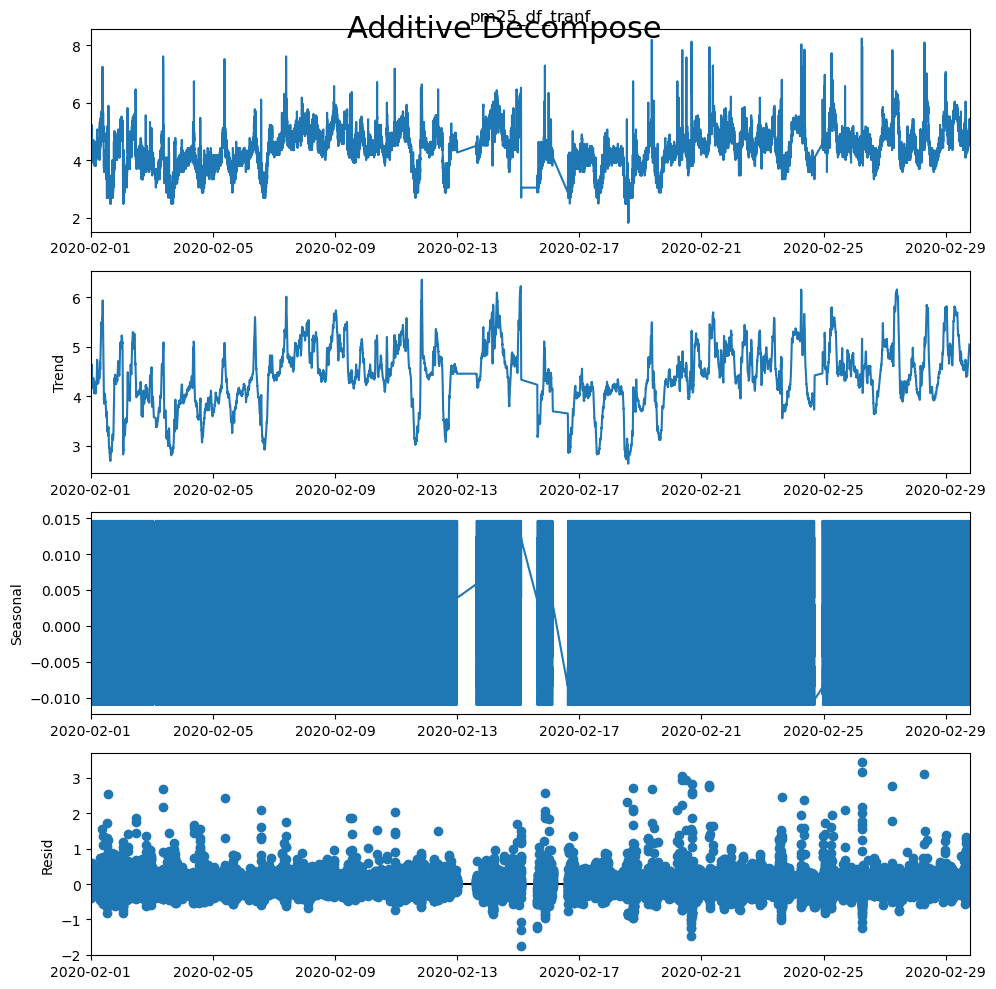

In [18]:
# Basado en https://mlstudio.jaol.net/analisis-de-series-temporales-python/
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(datosTest[nsensor], model='multiplicative', extrapolate_trend='freq')
# No aplica para este dataset porque tiene valores negativos y ceros.

# Additive Decomposition
result_add = seasonal_decompose(datosTest[nsensor], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### Holt-Winters’ Seasonal Method

Suitable for time series data with trend and/or seasonal components

The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ.

There are two general types of seasonality: Additive and Multiplicative. 

Additive: xt = Trend + Seasonal + Random

Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.

Multiplicative: xt = Trend * Seasonal * Random

The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.

The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.

<img src="Holts Winters.png">

where s is the length of the seasonal cycle, for 0 ≤ α ≤ 1, 0 ≤ β ≤ 1 and 0 ≤ γ ≤ 1.

The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

<img src="additive-vs-multiplicative.png">


In [ ]:
# Basado en https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
# y en https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

from statsmodels.tsa.api import ExponentialSmoothing

a = len(datosTest)-50
b = len(datosTest)

fit1 = ExponentialSmoothing(datosTest[nsensor] ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
fcast1 = fit1.forecast(24)
mse1 = ((fit1.fittedvalues - datosTest[nsensor]) ** 2).mean()
print('The Root Mean Squared Error of Holt''s Winter trend {}'.format(round(np.sqrt(mse1), 2)))

lista1 = {'Metodo':'Holt-Winter', 'Parámetros':'Aditivo', 'RMSE':round(np.sqrt(mse1), 2)}
rmse = rmse.append(lista1, ignore_index=True)

plt.figure(figsize=(16,8))
plt.plot(datosTest[nsensor][a:b], label='Reales', marker="o")
plt.plot(fit1.fittedvalues[a:b], label='Holt_Winter', marker="o")
#plt.plot(fcast1, label='Forecast', marker="o")
plt.legend(loc='best')
plt.show()

### MODELO SARIMA

In [ ]:
# Basado en https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

fit1 = sm.tsa.statespace.SARIMAX(datosTest[sensor], order=(2, 1, 4),seasonal_order=(0,1,1,7))
#fit1 = sm.tsa.statespace.SARIMAX(datosTest[sensor], order=(2, 1, 4))
resultados = fit1.fit() 
#y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
datosTest['pronostico_sarima'] = resultados.fittedvalues.shift(-1)
mse1 = ((resultados.fittedvalues.shift(-1) - datosTest[sensor]) ** 2).mean()
print('The Root Mean Squared Error of SARIMA trend {}'.format(round(np.sqrt(mse1), 2)))

lista1 = {'Metodo':'SARIMA', 'Parámetros':'(2,1,4)', 'RMSE':round(np.sqrt(mse1), 2)}
rmse = rmse.append(lista1, ignore_index=True)

plt.figure(figsize=(16,8))
plt.plot(datosTest[sensor], label='Real')
plt.plot(resultados.fittedvalues, label='SARIMA')
plt.plot(resultados.resid, label='Residuales')
#plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [ ]:
rmse

In [ ]:
resultados.summary()

### MODELO ESTACIONAL ADITIVO (NO TENDENCIA, SI ESTACIONALIDAD)

##### El método estacional aditivo divide los datos históricos entre un nivel base (L) o el componente básico definido por el parámetro alfa, y un componente de estacionalidad (S) medido por el parámetro gamma. El valor de pronóstico resultante es simplemente la adición del nivel del caso base y el valor de la estacionalidad.
<img src="estacional_aditivo.png">

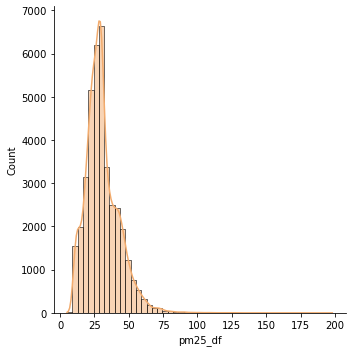

In [7]:
import seaborn as sb


#intervalos = range(min(datosTest[nsensor]), max(datosTest[nsensor]) + 2)

sb.displot(datosTest[nsensor], color='#F2AB6D', bins=50, kde=True)

#plot.xticks(rangos)
#plot.ylabel('Frecuencia')
#plot.xlabel('Edades')
#plot.title('Histograma de edades - Seaborn - codigopiton.com')

#plot.show()

#plt.figure()
#plt.hist(datosTest[nsensor])
#plt.show()

In [ ]:
s = 24
alpha = 0.1
gamma = 0.2

# Preparación del Dataframe
pron_add = pd.DataFrame()
pron_add[sensor] = datos[sensor]

# Calculo de semillas
semilla_L = datosTest[sensor][0:s].mean() 
pron_add.loc[s-1,'L'] = semilla_L
pron_add['S'] = pron_add[sensor][:s] - semilla_L


print(pron_add[20:30])


# Calculo de los componentes
#pron_add['L'] = pron_add.loc[pron_add['L'] != np.nan, (alpha*(pron_add[sensor]-pron_add['S'].shift(s))) + ((1-alpha)*pron_add['L'].shift(s))]

for i in range (s,len(pron_add)):
    pron_add.loc[i,'L'] = (alpha*(pron_add.loc[i,sensor]-pron_add.loc[i-s,'S'])) + ((1-alpha)*pron_add.loc[i-1,'L'])
    pron_add.loc[i,'S'] = (gamma*(pron_add.loc[i,sensor]-pron_add.loc[i,'L'])) + ((1-gamma)*pron_add.loc[i-s,'S'])
    pron_add.loc[i,'pron'] = pron_add.loc[i-1,'L'] + pron_add.loc[i-s,'S']
pron_add[20:40]




In [6]:
a = 0
b = 210
#b = len(pron_add)
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(pron_add[a:b].index, pron_add[a:b]['L'], label=sensor)
plt.plot(pron_add[a:b].index, pron_add[a:b]['S'], label='Pronostico')
#plt.axhline(y=datosTest[a:b][sensor].mean(), color='r', linestyle='-')
plt.legend(loc='upper center')
plt.show()

NameError: name 'pron_add' is not defined

<Figure size 1200x500 with 0 Axes>

In [ ]:
sum(i <= 0 for i in datosTest[sensor])


In [4]:
from scipy import stats
import matplotlib.pyplot as plt

xt,lmbda = stats.boxcox(datosTest[sensor])
datosTest['boxcox'] = xt
lmbda

0.15652659629263094

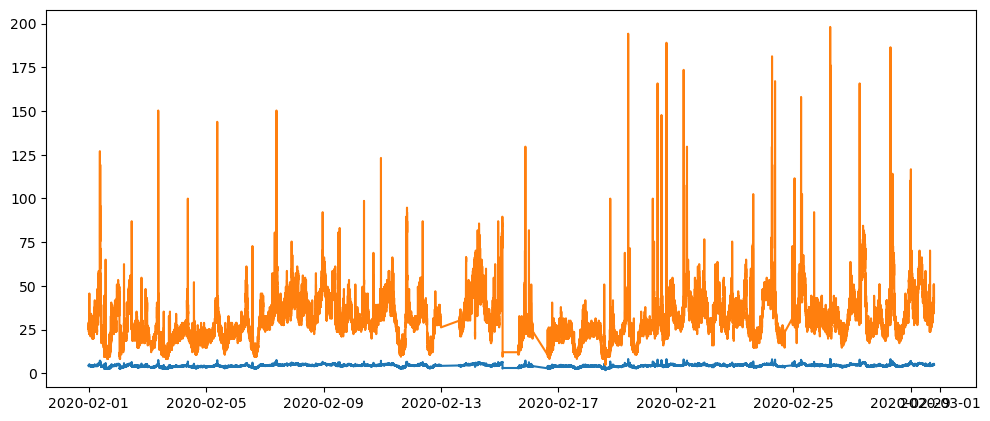

In [5]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(datosTest['boxcox'], label='boxcox')
plt.plot(datosTest[sensor], label=sensor)

In [ ]:
import funciones_TS as f_TS

